Avant de commencer : <br>
`conda install graphviz`

Aujourd'hui on commence par le cours avant de dérouler le notebook.

La progression de ce notebook :
- On commence par un peu de cours sur la construction d'arbres.
- Puis on introduit un exemple facile à visualiser, les données Iris.
- Ensuite on s'échauffe : on plante un arbre sur les données Iris pour découvrir l'interface scikit-learn (et ses limites).
- On revient au cours pour voir comment on peut construire un comité d'experts qui sera meilleur que chaque expert individuellement et qui sera très performant in fine. Cela nous fournit le méta-algorithme du Boosting que l'on applique sur des experts "arbres".
- On implémente ensuite un Boosting d'arbres sur des données simulées.
- Enfin on s'entraîne sur la méthode de Boosting de scikit-learn.

On commence par les imports classiques.

In [1]:
from sklearn import datasets
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.ensemble import AdaBoostClassifier
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from os import system
from IPython.display import Image

## Arbres de classification

Le jeu de données iris décrit trois espèces d'Iris (setosa, versicolor et virginica) en fonction de 4 caractéristiques (longueur de sépale, largeur de sépale, longueur de pétale, largeur de pétale).

In [2]:
iris = datasets.load_iris()
print(iris.data.shape)
print(iris.target.shape)
print(iris.target_names)
print(iris.feature_names)

(150, 4)
(150,)
['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


On va entrainer un premier arbres pour classer les Iris.

In [3]:
iris_dt = tree.DecisionTreeClassifier()
iris_dt.fit(iris.data, iris.target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Affichons le résultat de cet entraînement.

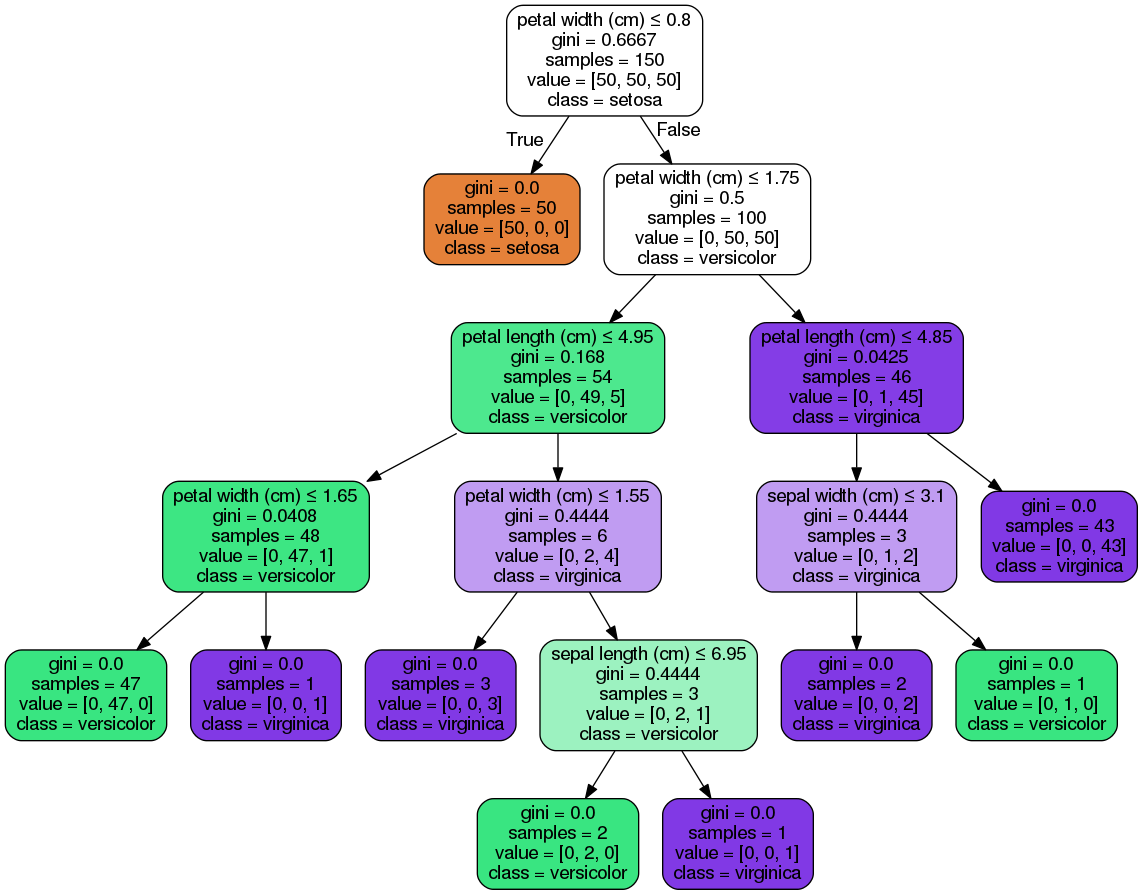

In [4]:
def disp_iris_tree(filename, treename):
    dotfile = open(filename+'.dot', 'w')
    tree.export_graphviz(treename, 
                         out_file = dotfile, 
                         feature_names = iris.feature_names,
                         class_names=iris.target_names,  
                         filled=True,
                         rounded=True,  
                         special_characters=True)
    dotfile.close()
    system("dot -Tpng "+filename+".dot -o "+filename+".png")
    return Image(filename+'.png')
   
disp_iris_tree('iris_dt',iris_dt)

<div class="alert alert-warning">
Etudions un peu le contenu de cet arbre et sa construction.
<ul>
<li> Au noeud racine, tous les exemples sont présents.
<li> On cherche alors la variable et le seuil qui vont permettre le meilleur gain sur le critière d'impureté (Gini ici). Il apparaît que le critère "petal width $\leq 0.8$" permet de bien classer tous les Iris Setosa et permet ainsi la plus forte réduction d'impureté (réduction de $150\cdot 0.6667 - 50\cdot0 - 100\cdot0.5 = 50.005$.
<li> Le premier noeud fils est pur, aucun gain sur le critère n'est possible.
<li> Le second noeud fils a, par contre, la pire valeur possible d'impureté de Gini.
<li> Mais une nouvelle coupe sur la largeur de pétale permet d'identifier deux familles distinctes d'Iris qui semblent présenter des grandes tendances.
<li> Une question se pose à ce stade : les exemples minoritaires dans ces deux grandes familles identifiées ne sont-ils pas dûs à du bruit ? Pour éviter le sur-apprentissage, ne devrait-on pas arrêter ici le développement de l'arbre ? Inversement, en s'arrêtant ici, ne risque-t-on pas de manquer des critères de classification essentiels pour décrire les espèces d'Iris ? A votre avis, comment répondre à cette question ?
<li> On a demandé à scikit-learn de développer l'arbre en entier jusqu'à avoir des noeuds purs, la recherche de coupes se poursuit donc de proche en proche.
<li> A la fin, l'arbre est complètement développé et on remarque de nombreuses feuilles qui ne comportent qu'un, deux ou trois exemples. A votre avis, ces feuilles sont-elles pertinentes ?
<li> L'arbre entièrement développé a été construit en maximisant, étape après étape un critère propre au noeud qu'on souhaite créer. L'arbre ainsi construit vous semble-t-il être l'arbre de taille minimale décrivant les données Iris ?
</ul>
</div>

<div class="alert alert-warning">
**Exercice**: A vous de jouer. <br/>
Explorons un peu les options de `tree.DecisionTreeClassifier` en entraînons un arbre avec critère de gain d'entropie et de profondeur maximum 3.
</div>

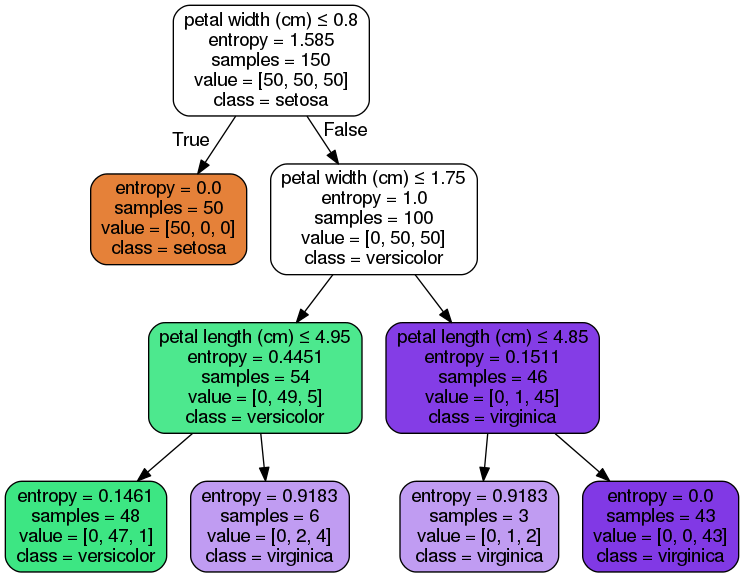

In [5]:
### REMOVE FROM CORRECTION
#?tree.DecisionTreeClassifier
iris_dt2 = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=3)
iris_dt2.fit(iris.data, iris.target)
disp_iris_tree('iris_dt2',iris_dt2)

On peut utiliser l'arbre pour la prédiction etle calcul d'erreur sur des bases de test.

In [6]:
x = np.array([3., 3., 5., 0.9])
x = x.reshape(1,4)
print(iris.target_names[iris_dt2.predict(x)])
print(iris_dt2.predict_proba(x))
print(iris_dt2.predict_log_proba(x))
print(iris_dt2.score(iris.data,iris.target))

['virginica']
[[ 0.          0.33333333  0.66666667]]
[[       -inf -1.09861229 -0.40546511]]
0.973333333333


/home/emmanuel/anaconda3/lib/python3.5/site-packages/sklearn/tree/tree.py:715: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


Malheureusement, si on peut limiter le nombre de feuilles d'un arbre, `scikit-learn` n'implémente pas pour l'instant de méthodes d'élagage et nécessite l'usage de la fonction `Imputer` pour traiter les valeurs manquantes. De plus, l'inspection des propriétés de l'arbre (profondeur, nombre de feuilles...) n'est pas aisée. On s'arrêtera donc là pour ce TP, en gardant à l'esprit que de nombreux autres packages incluent cette fonctionnalité essentielle, en particulier les packages `Rpart` et `tree` en R (et que ça ne devrait pas tarder dans `scikit-learn`).<br>

Cela ne nous empêchera pas cependant d'implémenter un algorithme de Boosting.

## Boosting

Retour au cours pour poser les intuitions et la théorie. <br>
<br>
On va commencer par quelque chose de visualisable.

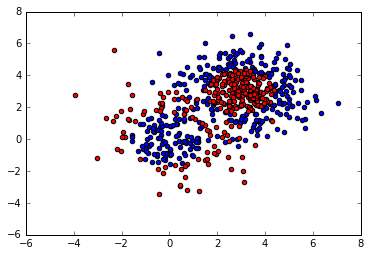

In [7]:
X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
y = 2*y-1

X, y = shuffle(X, y)

Xtest,X = np.split(X,[400])
ytest,y = np.split(y,[400])

Xblue = X[y==-1]
Xred = X[y==1]
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
_=plt.scatter(Xred[:,0],Xred[:,1],c='r')

On construit un premier arbre et on l'affiche.

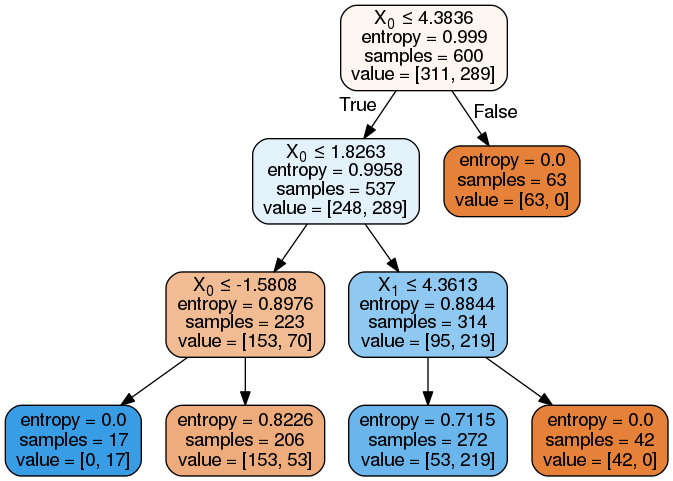

In [8]:
dt1 = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)
dt1.fit(X,y)

def disp_tree(filename, treename):
    dotfile = open(filename+'.dot', 'w')
    tree.export_graphviz(treename, 
                         out_file = dotfile,
                         filled=True,
                         rounded=True,  
                         special_characters=True)
    dotfile.close()
    system("dot -Tpng "+filename+".dot -o "+filename+".png")
    return Image(filename+'.png')

disp_tree('dt1',dt1)

On souhaite afficher la frontière de décision de l'arbre. On en profite pour mettre en évidence les points mal classés (triangles en cyan et magenta).

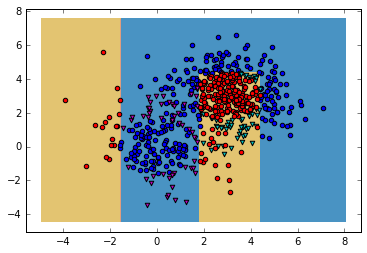

Erreur d'apprentissage : 0.176667
Erreur de généralisation : 0.21


In [24]:
def plot_decision_boundary_tree(t, X, y):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = t.predict(np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = t.predict(X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b')
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v')
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r')
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v')
    plt.show()

plot_decision_boundary_tree(dt1, X, y)
print("Erreur d'apprentissage : %g"%(1-dt1.score(X,y)))
print("Erreur de généralisation : %g"%(1-dt1.score(Xtest,ytest)))

Pour construire notre algorithme de Boosting, on va avoir besoin de fonctions qui évaluent le vote majoritaire d'un ensemble d'arbres (une forêt) et qui affichent la frontière de décision de la forêt.

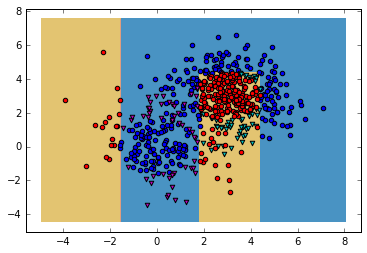

In [25]:
def forest_predict(f, weights, X):
    N = len(f)
    votes = np.zeros((X.shape[0],N))
    for i in range(N):
        votes[:,i] = weights[i]*f[i].predict(X)
    pred = np.sum(votes,axis=1)
    return np.sign(pred)

def plot_decision_boundary_forest(f, weights, X, y):
    plot_step = 0.02
    x0_min, x0_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x1_min, x1_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, plot_step), np.arange(x1_min, x1_max, plot_step))
    yypred = forest_predict(f, weights, np.c_[xx0.ravel(),xx1.ravel()])
    yypred = yypred.reshape(xx0.shape)
    plt.contourf(xx0, xx1, yypred, cmap=plt.cm.Paired)
    y_pred = forest_predict(f, weights, X)
    Xblue_good = X[np.equal(y,-1)*np.equal(y,y_pred)]
    Xblue_bad  = X[np.equal(y,-1)*np.not_equal(y,y_pred)]
    Xred_good  = X[np.equal(y,1)*np.equal(y,y_pred)]
    Xred_bad   = X[np.equal(y,1)*np.not_equal(y,y_pred)]
    plt.scatter(Xblue_good[:,0],Xblue_good[:,1],c='b')
    plt.scatter(Xblue_bad[:,0],Xblue_bad[:,1],c='c',marker='v')
    plt.scatter(Xred_good[:,0],Xred_good[:,1],c='r')
    plt.scatter(Xred_bad[:,0],Xred_bad[:,1],c='m',marker='v')
    plt.show()

forest = [dt1]
plot_decision_boundary_forest(forest,np.ones(1),X,y)

On va ainsi pouvoir mettre en oeuvre un algorithme de Boosting d'un ensemble d'arbres et visualiser l'évolution de la prédiction.<br>
<div class="alert alert-warning">
**Exercice**: A vous de jouer. <br/>
Avec les éléments ci-dessus, implémentez le Boosting d'une forêt de 100 arbres, entraînés sur les données précédentes.<br>
Affichez l'évolution des frontières de décision.<br>
Tracez l'évolution de l'erreur d'apprentissage et de l'erreur de généralisation en fonction du temps.
</div>

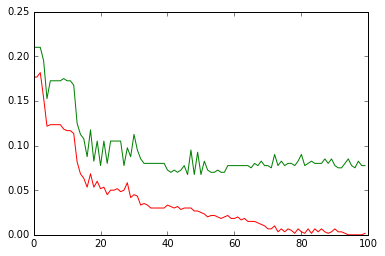

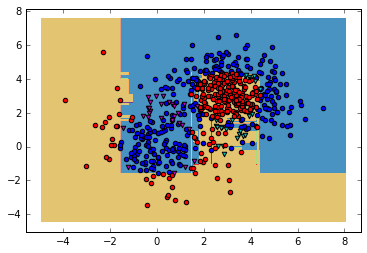

In [26]:
### REMOVE FOR STUDENTS
Nsteps = 100
forest = list()
sample_weights = np.ones(len(y))/len(y)
tree_weights = np.zeros(Nsteps)
single_tree_training_error = np.zeros(Nsteps)
overall_training_error = np.zeros(Nsteps)
generalization_error = np.zeros(Nsteps)
for i in range(Nsteps):
    # Train tree
    dt = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)
    dt.fit(X,y,sample_weight=sample_weights)
    # Compute error
    y_pred = dt.predict(X)
    classif_error = sum(np.not_equal(y_pred, y)*sample_weights) / sum(sample_weights)
    #classif_error = sum(y_pred!=y)/len(y)
    forest.append(dt)
    # Get tree weight
    alpha = .5*np.log((1-classif_error)/classif_error)
    tree_weights[i] = alpha
    # Update weights
    sample_weights = sample_weights*np.exp(-alpha*y_pred*y)
    sample_weights = sample_weights/sum(sample_weights)
    # Plot and store data
    #plot_decision_boundary_forest(forest, sample_weights, X, y)
    single_tree_training_error[i] = classif_error
    y_pred = forest_predict(forest, tree_weights, X)
    overall = sum(np.not_equal(y_pred, y))/len(y)
    overall_training_error[i] = overall
    y_pred = forest_predict(forest, tree_weights, Xtest)
    gen = sum(np.not_equal(y_pred, ytest))/len(ytest)
    generalization_error[i] = gen
    #print("Nb trees %d. Last tree error %.3g. Training error %.3g. Generalization error %.3g. Press Enter"
    #      %(len(forest),classif_error, overall, gen))
    #input()

#plt.plot(single_tree_training_error,c='b')
plt.plot(overall_training_error,c='r')
plt.plot(generalization_error,c='g')
plt.figure()
plot_decision_boundary_forest(forest, sample_weights, X, y)

<div class="alert alert-warning">Que remarque-t-on sur la tendance au sur-apprentissage ?</div>

Scikit-learn fournit un méta-algorithme Adaboost directement implémenté, autant l'utiliser.
<div class="alert alert-warning">A vous de jouer pour reproduire l'exemple précédent à partir de cette méthode.</div>
Pensez à jeter un oeil à la [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier).

In [12]:
boosted_forest = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=3), n_estimators=100)
boosted_forest.fit(X,y)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

<div class="alert alert-warning">Que donnerait l'implémentation d'un Boosting sur le problème de classification d'e-mails ? Et sur les données MNIST ?</div>
Pour vous aider sur les données MNIST, scikit-learn fournit un ensemble de jeux de données directement. Jetez un oeil à la [documentation](http://scikit-learn.org/stable/datasets/). Il y a notamment une fonction `load_digits()` qui fournit une version allégée de la base MNIST.